# The Code Developed

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
#introduce constants and conversion factors
epsilon=8.8541 * 10**(-12) #C^2 J^−1 m^−1
pi=3.14159
debeye=3.33564 * 10**(-30) #C m
angstrom=10**-10 #m
hartree = 1/(4.359744650*(10**-18))#2.294 * 10**17 #J
mu_0=1.855 * debeye
R=2.5 * angstrom
alpha_zz= 1.45 * angstrom**3 * 4 * pi * epsilon
e=1.60217662 * 10**(-19) #C
lj_epsilon=1.08 * 10**-21 #J
lj_sigma=3.165 * angstrom

In [3]:
def induced_field_si(R,mu,charge):
    return (2*mu)/(4*pi*epsilon*(abs(R)**3))+(charge/(4*pi*epsilon*(abs(R)**2)))

In [4]:
#Calculate electrostatic energy of each molecule from final converged dipoles
def calc_electrostatic(mol_orig,R):
    mol=copy.deepcopy(mol_orig)
    for molecule in mol:
            molecule[0]=molecule[0]*R

    electrostatic_dipole_dipole=[0]*len(mol_orig)
    electrostatic_charge_dipole=[0]*len(mol_orig)
    
    for index in range(0,len(mol)):
                #create new list and remove current molecule
                temp_mol=copy.deepcopy(mol)
                
                del temp_mol[:index+1]
                total_force_change=0
                total_charge_dipole=0
                #loop over other molecules to find net force 
                for molecule in temp_mol:
                    r_z=molecule[0]-mol[index][0] #calc seperation
                    f_z=induced_field_si(abs(r_z),molecule[1],molecule[2]) #calc force
                    total_force_change+=f_z #sum total force
                    f_dot_r=f_z*r_z
                    total_charge_dipole+=mol[index][2]*f_dot_r
                    

                #calc properties
                electrostatic_dipole_dipole[index]= -total_force_change*mol[index][1]
                electrostatic_charge_dipole[index]=total_charge_dipole
    return sum(electrostatic_dipole_dipole)+sum(electrostatic_charge_dipole)

In [5]:
def calc_induction(mol_orig,R,pol):
    mol=copy.deepcopy(mol_orig)
    for molecule in mol:
        molecule[0]=molecule[0]*R
    induction_energy=[0]*len(mol_orig)
    for index in range(0,len(mol)):
                if mol[index][1]==0:
                    continue
                    
                #create new list and remove current molecule
                temp_mol=copy.deepcopy(mol)
                temp_mol.pop(index)
                #del temp_mol[:index+1]
                total_force_change=0
                #loop over other molecules to find net force 
                for molecule in temp_mol:
                    r_z=abs(molecule[0]-mol[index][0]) #calc seperation
                    f_z=induced_field_si(r_z,molecule[1],molecule[2]) #calc force
                    total_force_change+=f_z #sum total force

                #calc properties
                induction_energy[index]= -0.5*(total_force_change**2)*pol
    return sum(induction_energy)

In [6]:
def calc_lj_energy(mol_orig,R):
    mol=copy.deepcopy(mol_orig)
    for molecule in mol:
            molecule[0]=molecule[0]*R
    lj_energy=[0]*len(mol_orig)
    for index in range(0,len(mol)):
                #create new list and remove current molecule
                temp_mol=copy.deepcopy(mol)
                
                del temp_mol[:index+1]
                lj_e_molecule=0
                #loop over other molecules to find net force 
                for molecule in temp_mol:
                    r_z=molecule[0]-mol[index][0] #calc seperation
                    lj_e_molecule+=4*lj_epsilon*((lj_sigma/abs(r_z))**12-(lj_sigma/abs(r_z))**6)

                
                lj_energy[index]=lj_e_molecule
    return sum(lj_energy)
    

In [7]:
# Function to determine required enhance dipole
def find_enhanced_dipole(mol_orig,mu_0,R,energy_target,threshold):
    mol_new=copy.deepcopy(mol_orig)
    #scale particle seperations by R
    for molecule in mol_new:
        molecule[0]=molecule[0]*R
    mol_new=np.array(mol_new)
    #set initial starting guess
    mu_guess=mu_0
    energy_guess=0
    #perform search untill difference from target smaller than threshold
    while abs((energy_guess-energy_target)/energy_target)>threshold:
        mol_new=np.array(mol_new)
        # set system dipoles to guess dipole
        mol_new[:,1]=mu_guess
        mol_new=mol_new.tolist()
        # calculate electrostatic energy of sysytem
        energy_guess=calc_electrostatic(mol_new,1)
        # incremente dipole guess depending energy
        if energy_guess>energy_target:
            mu_guess+=0.0001 * debeye
        elif energy_guess<energy_target:
            mu_guess-=0.0001 * debeye
    
    return mu_guess
    

In [30]:

def dipoles_and_induction(mol_orig,R,threshold=10**-4 *debeye):
    
    mol=copy.deepcopy(mol_orig)   
    #scale particle seperations
    for molecule in mol:
        molecule[0]=molecule[0]*R
    mol_new=copy.deepcopy(mol)
    mol_added=np.array(copy.deepcopy(mol))
    
    
    
    #initialize data frams for output 
    df_dipoles_induced=pd.DataFrame(np.array(mol)[:,0:2])
    df_dipoles_induced.rename({0:'pos',1:'0'},axis=1,inplace=1)
    df_induction_energy=pd.DataFrame()
    df_induction_energy['0']=[calc_induction(mol,1,alpha_zz)]
    df_electrostatic_energy=pd.DataFrame()
    df_electrostatic_energy['0']=[calc_electrostatic(mol,1)]
    df_dipoles_added=pd.DataFrame(np.array(mol)[:,0:2])
    df_dipoles_added.rename({0:'pos',1:'0'},axis=1,inplace=1)
    
   
    
    #initiate termporary lists 
    mu_induced=[0]*len(mol)
    mu_change=[1]*len(mol)
    induction_energy=[0]*len(mol)
    electrostatic_energy=[0]*len(mol)

    
    itterations=0
    #main loop 
    while (max(abs(np.array(mu_change)))>threshold):
        itterations+=1
        mol_new.clear()
        mol_new=copy.deepcopy(mol)
        #loop over each molecule
        for index in range(0,len(mol)):

                    
            
            #create new list and remove current molecule
            temp_mol=copy.deepcopy(mol)
            temp_mol.pop(index)

            total_mu_change=0
            total_force_change=0
            #loop over other molecules to find net force 
            for molecule in temp_mol:
                r_z=molecule[0]-mol_new[index][0] #calc seperation
                f_z=induced_field_si(r_z,molecule[1],molecule[2]) #calc force
                total_force_change+=f_z #sum total force

            #calc properties
            #electrostatic_energy[index]= -total_force_change*mol[index][1]
            if mol_new[index][1]==0:
                mu_change[index]=0
            else:
                mu_change[index]=total_force_change*alpha_zz
            #induction_energy[index]=-0.5*alpha_zz*(total_force_change**2)
            #update mol list 
            mol_new[index][1]=mu_change[index] 
        #set charge on ion to zero after first iteration
        #since only interested in field from induced dipooles thereafter
        mol_new[0][2]=0
        #update data frames
        
        df_dipoles_induced[str(itterations)]=mu_change
        
        
        
        mol.clear()
        mol=copy.deepcopy(mol_new)
        
        mol_added[:,1]=mol_added[:,1]+(np.array(mol))[:,1]
        df_dipoles_added[str(itterations)]=list(mol_added[:,1])
        induction_energy=calc_induction(list(mol_added),1,alpha_zz)
        df_induction_energy[str(itterations)]=[induction_energy]
        electrostatic_energy=calc_electrostatic(list(mol_added),1)
        df_electrostatic_energy[str(itterations)]=[electrostatic_energy]
        
        
        
        #exit if more than 500 iterations needed
        if (itterations > 500) :
            print ("exceeded max")
            print (mu_change)
            print (mol)
            break
    #return dataframes 
    df_dipoles_induced['final']=df_dipoles_induced.loc[:,'0':].sum(axis=1)
    df_dipoles_induced.loc[:,"0":]=df_dipoles_induced.loc[:,"0":]/debeye
    df_dipoles_added.loc[:,"0":]=df_dipoles_added.loc[:,"0":]/debeye
    df_dipoles_induced['pos']=df_dipoles_induced['pos']/angstrom
    df_dipoles_added['pos']=df_dipoles_added['pos']/angstrom


    final_electrostatic=df_electrostatic_energy[str(itterations)]
    final_induction=df_induction_energy[str(itterations)][0]
    final_lennard_jones=calc_lj_energy(mol,1)
    return [df_dipoles_induced,df_induction_energy,df_electrostatic_energy,df_dipoles_added,\
            [final_electrostatic,final_induction,final_lennard_jones]]






# Question 1
Consider a set of 5 neutral, dipolar molecules each separated by a distance $R$. The dipoles are aligned along the z-direction and are of magnitude $\mu=1.855$ Debye. The molecules have a dipole polarisability of $\frac{\alpha_{zz}}{4\pi \epsilon_0}=1.45$ $Angstrom^3$ ($A^3$). The electric field generated by a dipole in the z direction is given by,
\begin{equation}
\vec{F}_z= \frac{2\vec{\mu}_z}{4\pi \epsilon_0 R^3}.
\label{eq1}
\end{equation}
The dipole moment of a molecule can be expanded in terms of an external electric field (generated by the other molecules), leading to the following expression,
\begin{equation}
\mu_z=\mu_z^0+\sum_\beta \alpha_{z\beta}F_\beta
\end{equation}
where $\mu_0$ is the intrinsic dipole and the second term is the induced dipole. Because our dipoles are aligned along z, this simplifies to,
\begin{equation}
\mu_z=\mu_z^0+ \alpha_{zz}F_z.
\end{equation}
Higher order terms could be included but are neglected here. The electric field is (vector) additive and so $F_z$ refers to the sum of the fields produced by the other dipole molecules. 


The induction energy for a molecule due to the presence of the other dipoles can also be calculated using,
\begin{equation}
U^{ind}=-\frac{1}{2}\alpha_{zz}F_z^2.
\end{equation}


The electrostatic energy in this system only arrises form dipole-dipole interactions because the molecules are all neutral. The dipole-dipole contribution to electrostatic energy is given by,
\begin{equation}
U^{elec}=-\mu_zF_z,
\end{equation}
where $\mu_z$ is the dipole of the molecule and $F_z$ the electric field due to the other dipoles.

The dipoles induced by the electric field generated by the other dipoles is calculated using an iterative approach. At each step of the iteration, the induction due to only the previously calculated induced dipoles is calculated. The final dipoles are then the sum over the induced dipoles at every iteration. The convergence threshold for the dipoles is set at $10^{-4}$ Debye. Induction energies and electrostatic energies are calculated from the cumulative dipoles at each iteration. 

## Calculations at 2.5 Angstrom
First, a nested list is created to represent the molecules in the system. Each nested list contains the position, dipole and charge of the molecule. 

In [31]:
# set up 5 dipoles of strength mu_0 aligned along z with zeoro charge 
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
# calculate induced dipoles and energies iteratively, R=2.5 Angstrom
dipole, induction, electrostatic, dipole_added,energies = \
    dipoles_and_induction(mol_orig,2.5*angstrom)

The dipoles calculated are shown in the table below in units of Debye. Column 0 holds the initial dipole strength $\mu_0=1/855$ Debye. The induced dipoles at each iteration are shown and the final dipoles are given in the last column. 10 iterations were needed till convergence to order of $10^{-5}$ Debye. Because the dipoles are all aligned, the induction effect is positive. The smallest induction is observed on the outer dipoles, which are on average farther away from the other dipoles. The systems is symmetric about the central, third dipole (index 2), and this is reflected by the induced dipoles of the first (index 0) and fifth (index 4) and second (1) and fourth (3) molecules being equal in magnitude. The central dipole experiences the largest induction because it is on average closer to the other dipoles, and hence the induced electric field is stronger. 

In [32]:
# Induced and final dipoles at 2.5 Angstrom
dipole

,pos,0,1,2,3,4,5,6,7,8,9,10,final
0,0.0,1.855,0.405455,0.162418,0.053335,0.020016,0.006729,0.002481,0.000846,0.000308,0.000106,0.000038,2.506733
1,2.5,1.855,0.744363,0.239083,0.091582,0.030261,0.011323,0.003815,0.001404,0.000480,0.000174,0.000060,2.977547
2,5.0,1.855,0.774648,0.295121,0.096284,0.036470,0.012161,0.004515,0.001531,0.000560,0.000192,0.000070,3.076554
3,7.5,1.855,0.744363,0.239083,0.091582,0.030261,0.011323,0.003815,0.001404,0.000480,0.000174,0.000060,2.977547
4,10.0,1.855,0.405455,0.162418,0.053335,0.020016,0.006729,0.002481,0.000846,0.000308,0.000106,0.000038,2.506733


The total induction energy at each iteration is shown below in units of Hartree. The induction energy is negative, as expected,  which implies that the system adopts a more stable configuration due to inductive processes. The difference in induction energies between iterations falls at lower iterations which corresponds to the smaller changes in induced dipoles at later iterations. The induction energy has converged on the order of $10^{-6}$ Hartree. Thus, the induction energy has converged to a similar level as the induced dipoles. 

In [33]:
#induction energies at 2.5 Angstrom 
induction*hartree

,0,1,2,3,4,5,6,7,8,9,10
0,-0.016112,-0.029452,-0.03514,-0.037267,-0.038035,-0.038308,-0.038405,-0.038439,-0.038451,-0.038455,-0.038457


The electrostatic energy is also calculated form the cumulative dipoles at each iteration and the results are summarized on the table below. The electrostatic energies are larger than the induction energies and increase in magnitude as the total dipoles grow. The electrostatic energy is negative because the only contributing term is the dipole-dipole interaction which has a negative sign. 

In [35]:
#electrostatic energies at 2.5 Angstrom
electrostatic*hartree

,0,1,2,3,4,5,6,7,8,9,10
0,-0.045106,-0.082994,-0.099054,-0.105081,-0.10725,-0.108023,-0.108297,-0.108394,-0.108428,-0.10844,-0.108444


## Calculations with 3.5 Angstrom

In [38]:
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
# calculate induced dipoles and energies iteratively, R=3.5 Angstrom
dipole, induction, electrostatic, dipole_added, energies = \
    dipoles_and_induction(mol_orig,3.5*angstrom)

Next the same calculations are done with an intermolecular separation of 3.5 Angstroms. Only 5 iterations are needed to converge. This is as expected as the inductions effects will be smaller due the $\frac{1}{R^3}$ dependence of the dipole induced fields. The final dipoles, as shown below, are smaller but the symmetry and relative sizes have not changed.  

In [39]:
# Induced and final dipoles at 3.5 Angstrom
dipole

,pos,0,1,2,3,4,5,final
0,0.0,1.855,0.147761,0.021571,0.002581,0.000353,0.000043,2.027309
1,3.5,1.855,0.271269,0.031753,0.004433,0.000534,0.000073,2.163061
2,7.0,1.855,0.282306,0.039195,0.004660,0.000643,0.000078,2.181883
3,10.5,1.855,0.271269,0.031753,0.004433,0.000534,0.000073,2.163061
4,14.0,1.855,0.147761,0.021571,0.002581,0.000353,0.000043,2.027309


As expected, the magnitude of the induction energies has fallen dramatically, by an order of magnitude. The induction energy depends on the square of the fields and so has a very strong $\frac{1}{R^6}$ dependence. Again, the induction energies have converged on the order $10^{-6}$ Hartree. 

In [40]:
# Induction energies at 3.5 Angstrom
induction*hartree

,0,1,2,3,4,5
0,-0.00214,-0.002724,-0.002804,-0.002815,-0.002816,-0.002816


The electrostatic energy has also significantly fallen but the difference is less pronounced because the electric field terms depend on the force and not the square of the forces as the induction energies. 

In [41]:
# Electrostatic energies at 3.5 Angstrom
electrostatic*hartree

,0,1,2,3,4,5
0,-0.016438,-0.020992,-0.021616,-0.021697,-0.021707,-0.021709


## Calculations with 4.5 Angstrom

In [42]:
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
# calculate induced dipoles and energies iteratively, R=4.5 Angstrom
dipole, induction, electrostatic, dipole_added, energies = \
    dipoles_and_induction(mol_orig,4.5*angstrom)

Finally the results for calculations with 4.5 Angstrom separation are presented below. These results follow the same trends as discussed for 3.5 Angstroms. Only 4 iterations are needed for convergence. The induction effects are almost negligible with induction energies of order $10^{-4}$ Hartree. As a result, the difference in final dipoles between the molecules are less pronounced and the electrostatic energy dominates the total energy. 

In [44]:
# Induced and final dipoles at 4.5 Angstrom
dipole

,pos,0,1,2,3,4,final
0,0.0,1.855,0.069522,0.004775,0.000269,0.000017,1.929584
1,4.5,1.855,0.127634,0.007029,0.000462,0.000026,1.990152
2,9.0,1.855,0.132827,0.008677,0.000485,0.000032,1.997021
3,13.5,1.855,0.127634,0.007029,0.000462,0.000026,1.990152
4,18.0,1.855,0.069522,0.004775,0.000269,0.000017,1.929584


In [45]:
# Induction energies at 4.5 Angstrom
induction*hartree

,0,1,2,3,4
0,-0.000474,-0.000533,-0.000536,-0.000536,-0.000536


In [46]:
#electrostatic energies at 4.5 Angstrom
electrostatic*hartree

,0,1,2,3,4
0,-0.007734,-0.00871,-0.008771,-0.008775,-0.008775


# Question 2

Instead of iteratively solving for the induced dipoles, a artificially enhanced dipole can be used to simulate the presences of induction effects. The electrostatic energy resulting from this enhanced dipole should equal the sum of the electrostatic and induction energies found from the iterative approach. A small function, find_enhanced_dipole(mol_orig,mu_0,R,energy_target,threshold) was written to find the required enhanced dipole to produce the same total energy passed via the energy_target variable. The threshold variable determines to within what accuracy the energies must match. The value of $0.001\%$ is used below.

In [47]:
# Function to determine required enhance dipole
def find_enhanced_dipole(mol_orig,mu_0,R,energy_target,threshold):
    mol_new=copy.deepcopy(mol_orig)
    #scale particle seperations by R
    for molecule in mol_new:
        molecule[0]=molecule[0]*R
    mol_new=np.array(mol_new)
    #set initial starting guess
    mu_guess=mu_0
    energy_guess=0
    #perform search untill difference from target smaller than threshold
    while abs((energy_guess-energy_target)/energy_target)>threshold:
        mol_new=np.array(mol_new)
        # set system dipoles to guess dipole
        mol_new[:,1]=mu_guess
        mol_new=mol_new.tolist()
        # calculate electrostatic energy of sysytem
        energy_guess=calc_electrostatic(mol_new,1)
        # incremente dipole guess depending energy
        if energy_guess>energy_target:
            mu_guess+=0.0001 * debeye
        elif energy_guess<energy_target:
            mu_guess-=0.0001 * debeye
    
    return mu_guess
    

First, the total energies of the system at separations of 2.5, 3.5 and 4.5 Angstrom are calculated to then feed to the enhanced dipole finder. 

In [48]:
# Calculate total energy (electrostatic + induced) at 2.5 Angstrom 
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added, energies = \
    dipoles_and_induction(mol_orig,2.5*angstrom)
total_energy_2_5=float(energies[0]+energies[1])
total_energy_2_5*hartree

-0.1469009230049121

In [49]:
# Calculate total energy (electrostatic + induced) at 3.5 Angstrom 
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added, energies = \
    dipoles_and_induction(mol_orig,3.5*angstrom)
total_energy_3_5=float(energies[0]+energies[1])
total_energy_3_5*hartree

-0.024524962408504967

In [50]:
# Calculate total energy (electrostatic + induced) at 5.5 Angstrom 
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added, energies = \
    dipoles_and_induction(mol_orig,4.5*angstrom)
total_energy_4_5=float(energies[0]+energies[1])
total_energy_4_5*hartree

-0.009311285698992004

These total energies are now fed to the enhanced dipole function to find the necessary enhanced dipoles to generated these energies from purely electrostatic effects. The enhanced dipoles at 2.5, 3.5 and 4.5 Angstrom are calculated below and displayed in Debye.  

In [61]:
# Calc enhanced dipole at 2.5 Angstrom
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
mu_2_5=find_enhanced_dipole(mol_orig,mu_0,2.5*angstrom,total_energy_2_5,0.0001)
mu_2_5/debeye

3.3476000000007184

In [62]:
# Calc enhanced dipole at 3.5 Angstrom
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
mu_3_5=find_enhanced_dipole(mol_orig,mu_0,3.5*angstrom,total_energy_3_5,0.0001)
mu_3_5/debeye

2.2658000000001977

In [63]:
# Calc enhanced dipole at 4.5 Angstrom
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
mu_4_5=find_enhanced_dipole(mol_orig,mu_0,4.5*angstrom,total_energy_4_5,0.0001)
mu_4_5/debeye

2.0354000000000867

At a distance of 2.5 Angstrom, the required enhanced dipole is much larger than the original dipole of 1.855 Debye because at short distances, the induction effects are very strong, and the induction energies are relatively large. As the separation between molecules is increased, the induction energy falls of at a much faster rate than the electrostatic energy and hence smaller increases in the enhanced dipole are observed. At each separation, the enhanced dipole is larger than the largest induced dipole. This must be because the induction energy is "missing" and must be made up by artificially higher electrostatic energy due to stronger dipole-dipole interactions. At a separation of 4.5 Angstrom, the enhanced dipole is only slightly larger than the original dipole because, due to the larger distances, the induction effects are much smaller than electrostatic effects due to the scaling discussed in earlier sections. 

# Question 3

In this questions the system under investigation is changed to include a positively charged ($+1e$), non-polar ion at distance R to the left of the dipoles. The ion is assumed to be un-polarizable. To incorporate the ion into the code, the initial input list was modified by adding a molecule at position -1 with zero dipole and $+1e$ charge.

In [51]:
mol_orig=[[-1,0,1*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]

Calculations are performed using the same functions as previously. The introduction of a charged particle simply introduces a new source of electric fields. The field due to a charged particle is given by,
\begin{equation}
\vec{F}=\frac{Q}{48\pi\epsilon_0 R^2}\hat{R},
\end{equation}
where $Q$ is the charge and $\hat{R}$ is the unit vector of the direction of the field. Because the ion is located to the left and has positive charge, the field felt by the dipoles will be along the positive z-direction and is aligned with the dipoles. 
The function that calculates the electric fields is given below. The first term is the field generated by a dipole, the second the field generated by a charge.  

In [52]:
def induced_field_si(R,mu,charge):
    return (2*mu)/(4*pi*epsilon*(abs(R)**3))+\
            (charge/(4*pi*epsilon*(abs(R)**2)))

Because my iterative approach only uses the induced fields in each iteration past the first, the induction effect of the charged particle is only applied once in the first iteration. This is because the ion is not polarisable and only induced effects are calculated in later iterations. The positive ion should increase the dipoles because the electric field generated is aligned with those generated by the dipoles. The ion will also change the magnitude of the electrostatic term as the charged ion contributes to the total electrostatic energy by introducing charge-dipole terms to the system which are added explicitly in the function calculating electrostatic energy. The charge dipole terms are of the form,
\begin{equation}
U^{charge-dipole}=\frac{Q \vec{\mu} \cdot \vec{R}}{4\pi \epsilon_0 R^3}=Q(\vec{F}\cdot\vec{R}),
\end{equation}
where $Q$ is the charge and $\vec{F}$ the field generated by the dipole $\vec{\mu}$. These charge dipole terms should contribute positively to the total electrostatic energy because the charge $Q$ is positive and the field is aligned with the distance vector between the ion and the dipoles. 

## Calculations with 2.5 Angstrom

First, the induced dipoles and energies are calculated for the new system at a separation of 2.5 Angstrom. 

In [58]:
# Calculation of dipoles and energies iteratively at 2.5 Angstrom
mol_orig=[[-1,0,1*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added , energies = \
    dipoles_and_induction(mol_orig,2.5*angstrom)

The table below gives the induced and final dipoles for the molecules. As desired, the ion at index 0 is not polarisable. The presence of the ion increases the induced dipole in the vicinity of the ion. The field due to the charged ion decays with $\frac{1}{R^2}$ compared to the $\frac{1}{R^3}$ dependence of the dipole induced fields. As a result, the left most dipole has the largest final dipole. The introduction of the ion has broken the symmetry of the system and the central dipole is now weaker then those to its left due to its relatively large distance from the ion. Convergence is still reached after 10 iterations to the same order of accuracy. 

In [59]:
# Dipoles at 2.5 Angstrom
dipole

,pos,0,1,2,3,4,5,6,7,8,9,10,final
0,-2.5,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.855,1.519799,0.217604,0.098839,0.026744,0.010636,0.003356,0.001268,0.000423,0.000156,0.000053,3.733880
2,2.5,1.855,1.022949,0.470808,0.120008,0.049282,0.015067,0.005813,0.001905,0.000711,0.000240,0.000088,3.541871
3,5.0,1.855,0.898464,0.386640,0.149480,0.048029,0.018435,0.006080,0.002279,0.000767,0.000283,0.000096,3.365553
4,7.5,1.855,0.814010,0.284460,0.118211,0.043389,0.015163,0.005623,0.001913,0.000705,0.000241,0.000088,3.138802
5,10.0,1.855,0.450029,0.183364,0.065633,0.026520,0.009584,0.003376,0.001234,0.000425,0.000155,0.000053,2.595372


As expected from the increases in the dipoles, the induction energy has increased at each iteration due to the charge induced field. The final induction energy is about twice the magnitude as without the ion. 

In [60]:
# Induction energy at 2.5 Angstrom
induction*hartree

,0,1,2,3,4,5,6,7,8,9,10
0,-0.039773,-0.067303,-0.079118,-0.083435,-0.084997,-0.085549,-0.085745,-0.085814,-0.085839,-0.085847,-0.08585


Due to the introduction of a positive ion, the total electrostatic energy has become positive. This is because the positive charge-dipole terms are larger than the negative dipole-dipole terms. At each iteration past the first, the electrostatic energy falls, because the magnitude of the dipoles and hence the dipole-dipole terms is increased due to induction. 

In [61]:
# Electrostatic energy at 2.5 Angstrom
electrostatic*hartree

,0,1,2,3,4,5,6,7,8,9,10
0,0.050612,0.062226,0.050377,0.046092,0.044237,0.043604,0.043367,0.043285,0.043256,0.043245,0.043242


The total energy is still negative because at short separations, the negative induction energy is larger in magnitude than the electrostatic energy. 

In [62]:
# Total energy at 2.5 Angstrom
(induction+electrostatic)*hartree

,0,1,2,3,4,5,6,7,8,9,10
0,0.010839,-0.005077,-0.028741,-0.037343,-0.04076,-0.041945,-0.042378,-0.042529,-0.042583,-0.042602,-0.042609


## Calculation with 3.5 and 4.5 Angstrom
The same calculation is now repeated with 3.5 Angstrom and 4.5 Angstrom separation. 

In [63]:
# Calculation of dipoles and energies iteratively at 3.5 Angstrom
mol_orig=[[-1,0,1*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added , energies = \
    dipoles_and_induction(mol_orig,3.5*angstrom)

In [64]:
# Dipoles at 3.5 Angstrom
dipole

,pos,0,1,2,3,4,5,6,final
0,-3.5,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.855,0.716303,0.031832,0.005665,0.000519,0.000078,0.000009,2.609406
2,3.5,1.855,0.413405,0.074838,0.006359,0.001003,0.000106,0.000015,2.350728
3,7.0,1.855,0.345478,0.056212,0.008265,0.000929,0.000135,0.000016,2.266033
4,10.5,1.855,0.306803,0.040190,0.006237,0.000858,0.000107,0.000015,2.209210
5,14.0,1.855,0.170502,0.025465,0.003415,0.000514,0.000069,0.000009,2.054974


In [65]:
# Induction energy at 3.5 Angstrom
induction*hartree

,0,1,2,3,4,5,6
0,-0.007328,-0.008845,-0.00906,-0.009086,-0.00909,-0.00909,-0.00909


In [66]:
# Electrostatic energy at 3.5 Angstrom
electrostatic*hartree

,0,1,2,3,4,5,6
0,0.032398,0.040883,0.040887,0.040905,0.040904,0.040904,0.040904


At a separation of 3.5 Angstrom, the induction energy has become much smaller than the electrostatic energy and hence the total energy has become positive. 

In [68]:
# Total energy at 3.5 Angstrom
(induction+electrostatic)*hartree

,0,1,2,3,4,5,6
0,0.025069,0.032038,0.031827,0.031819,0.031814,0.031814,0.031814


The same trends are observed at 3.5 Angstrom with smaller final dipoles and lower induction energy due to increased separation. The induction energy has again decreased more dramatically than the electrostatic energy due to the different dependence on $R$ as discussed previously. Six iteration are needed for convergence as was the case for the system without the ion.

Below, the results at 4.5 Angstrom are calculated and again the same trends are observed with an overall decrease in the magnitude of dipoles and energies. Four iterations are needed as for the no-ion system.

In [69]:
# Calculation of dipoles and energies iteratively at 4.5 Angstrom
mol_orig=[[-1,0,1*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added , energies = \
    dipoles_and_induction(mol_orig,4.5*angstrom)

In [70]:
# Dipoles at 4.5 Angstrom
dipole

,pos,0,1,2,3,4,final
0,-4.5,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.855,0.413456,0.007696,0.000682,0.000028,2.276861
2,4.5,1.855,0.213618,0.019293,0.000720,0.000056,2.088686
3,9.0,1.855,0.171042,0.013520,0.000968,0.000050,2.040580
4,13.5,1.855,0.149130,0.009431,0.000703,0.000047,2.014311
5,18.0,1.855,0.083280,0.005884,0.000380,0.000027,1.944571


In [71]:
# Induction energy at 4.5 Angstrom
induction*hartree

,0,1,2,3,4
0,-0.002175,-0.002363,-0.002375,-0.002376,-0.002376


In [72]:
# Electrostatic energy at 4.5 Angstrom
electrostatic*hartree

,0,1,2,3,4
0,0.021808,0.025504,0.025552,0.025556,0.025557


The total energy is again positive but smaller than at 3.5 Angstrom due to the decrease in electrostatic energy at larger distances.

In [73]:
# Total energy at 4.5 Angstrom
(induction+electrostatic)*hartree

,0,1,2,3,4
0,0.019633,0.023141,0.023177,0.02318,0.02318


## How does the increase in induced dipoles due to this charge (ie. compared to part (i)) compare to the individual induced dipoles that q would induce in molecules 1 to 5, each in the absence of the other water molecules?

First consider the total increase in induction energy by adding the ion to the system. This is calculated by subtracting the induction energy in question 1 from the induction energy calculated with the ion. A distance of 2.5 Angstrom is used for this analysis.

In [151]:
# Calc dipoles and energies with ion
mol_orig=[[-1,0,1*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole_new, induction_new, electrostatic_new, dipole_added_new , energies_new = \
    dipoles_and_induction(mol_orig,2.5*angstrom)
# Calc dipoles and energies without ion
mol_orig=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
dipole, induction, electrostatic, dipole_added,energies = \
    dipoles_and_induction(mol_orig,2.5*angstrom)
# Change in dipoles due to ion at each iteration
x=dipole_new.loc["1":,:]
x.reset_index(drop=True,inplace=True)
(x-dipole).loc[:,"1":]

,1,2,3,4,5,6,7,8,9,10,final
0,1.114344,0.055186,0.045504,0.006729,0.003908,0.000875,0.000422,0.000115,0.000050,0.000015,1.227147
1,0.278586,0.231725,0.028425,0.019021,0.003743,0.001998,0.000501,0.000232,0.000066,0.000028,0.564325
2,0.123816,0.091519,0.053196,0.011559,0.006274,0.001564,0.000748,0.000206,0.000090,0.000027,0.288999
3,0.069646,0.045376,0.026629,0.013128,0.003840,0.001808,0.000509,0.000225,0.000066,0.000028,0.161256
4,0.044574,0.020946,0.012298,0.006504,0.002855,0.000895,0.000388,0.000116,0.000049,0.000015,0.088640


The table above shows the increase in induced dipoles due to the introduction of the ion to the system of dipoles. Indices 0 to 4 represent the dipoles from the left (0) to right (4) in positive z-direction. As discussed above, the inductive effect of the ion is most pronounced closest to the ion. 

Consider now the magnitude of the dipole induced in an individual dipole molecule in the absence of the other dipoles. Below, the induced dipole due to the ion onto dipoles 0 through 4 in the absence of all other dipoles are calculated. When compared to the increase in dipole due to the introduction of the ion into the system of dipoles above, the dipoles induced in isolated dipoles are smaller. This is because when other dipoles are present, these other dipoles also experience an induced dipole due to the ion which, in the next iteration, will induce a dipole in the other molecules. This secondary induction does not occur if only a single dipole is present. In this case, induction occurs only once, in a single iteration, because the ion itself cannot be polarised. 

In [153]:
# Calculate induced dipole in molecules in absence of other molecules
temp_dict={}
for i in range(0,5):
    mol_orig=[[-1,0,1*e],[float(i),mu_0,0]]
    dipole, induction, electrostatic, dipole_added,energies = \
        dipoles_and_induction(mol_orig,2.5*angstrom)
    temp_dict['Molecule '+str(i)]=dipole['1'][1]
induced_dipoles=pd.Series(temp_dict)
induced_dipoles

Molecule 0    1.114344
Molecule 1    0.278586
Molecule 2    0.123816
Molecule 3    0.069646
Molecule 4    0.044574
dtype: float64

# Question 4

We now use the enhanced dipoles calculated in question 2 in the ion system. First, set up the new list with dipoles set to the enhanced dipole at 2.5 Angstrom. 

In [100]:
#set up system with enhanced dipoles
mol_orig=[[-1,0,1*e],[0,mu_2_5,0],[1,mu_2_5,0],[2,mu_2_5,0],[3,mu_2_5,0],[4,mu_2_5,0]]

Next, use the electrostatic energy function to calculate the total electrostatic energy of the system with the enhanced dipoles. This energy is then compared to the total electrostatic+induction energy of $total\_energy=-0.042609$ Hartree from question 3.

In [154]:
total_energy=-0.042609
# Calc electrostatic energy for system with enhacned dipole
elec_static_enhanced=calc_electrostatic(mol_orig,2.5*angstrom)*hartree
elec_static_enhanced

0.002615944184656311

The calculated electrostatic energy from the enhanced dipole system is $0.02583$ Hartree which is does not correspond to the actual total energy of the system. The real total energy is negative, due to the strong negative contributions of the induction energy. The enhanced dipole form question 2 is not able to reproduce the enhancement in induction due to the the presence of the ion. It is clear, that the enhanced dipole method only works for the system for which the dipoles were calculated and can not easily be extended to systems with altered components. 

## Question 5

In this question, a 12-6 Lennard-Jones potential is added to the system of 5 dipoles as described in question 1. This additional potential is incorporated in the code as a new function which calculates the total energy due to the Lennard-Jones interaction in the sytem. The well depth is set to $\epsilon_0=1.08\times 10^{-21}$ and the molecule size is set to $\sigma=3.165$ Angstroms. The function for calculating the Lennard-Jones energy is shown below.

In [155]:
def calc_lj_energy(mol_orig,R):
    mol=copy.deepcopy(mol_orig)
    #scale intermolecular separation
    for molecule in mol:
            molecule[0]=molecule[0]*R
    #initialize list of energies 
    lj_energy=[0]*len(mol_orig)
    for index in range(0,len(mol)):
                #create new list and remove current molecule
                temp_mol=copy.deepcopy(mol)
                del temp_mol[:index+1]
                lj_e_molecule=0
                #loop over other molecules to find net force 
                for molecule in temp_mol:
                    r_z=molecule[0]-mol[index][0] #calc seperation
                    # calc lennard jones energy
                    lj_e_molecule+=4*lj_epsilon*((lj_sigma/abs(r_z))**12-\
                                                     (lj_sigma/abs(r_z))**6)

                lj_energy[index]=lj_e_molecule
    return sum(lj_energy)
    

Now need to generate the energies at a range of R values between 2.5 and 4.5 Angstroms. 

In [156]:
# Generate energies at different R values 
mol_new=[[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
R=np.arange(2.5,4.5,0.05)*angstrom
e1=[]
i1=[]
lj1=[]
for r in R:
    e1.append(float(dipoles_and_induction(mol_new,r)[-1][0]*hartree))
    i1.append(float(dipoles_and_induction(mol_new,r)[-1][1]*hartree))  
    lj1.append(float(dipoles_and_induction(mol_new,r)[-1][2]*hartree))
tot1=np.array(e1)+np.array(i1)+np.array(lj1)


These energies are now plotted below. Total energy, shown in red, is negative and tends to zero as the intermolecular separation is increased. This is as expected because the interactions between dipoles become weaker at longer distances. The Lennar-Jones energy is mostly positive and only dips below zero energy very briefly. This is because the well depth parameter $\epsilon_0$ is set to a very small value. In the range of separations studied here, the electrostatic energy dominates and the Lennard-Jones does not change the system energetics significantly. 

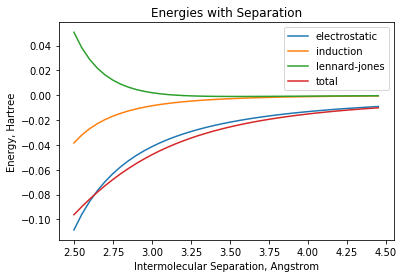

In [157]:
# Plot Energies
plt.title("Energies with Separation")
plt.xlabel("Intermolecular Separation, Angstrom")
plt.ylabel('Energy, Hartree')
plt.plot(R/angstrom,e1)
plt.plot(R/angstrom,i1)
plt.plot(R/angstrom,lj1)
plt.plot(R/angstrom,tot1)
plt.legend(['electrostatic','induction','lennard-jones','total'])

Out of curiosity, the energies for the system with the positive ion are calculated and plotted below. When the ion is included, the total energy is positive at all distances and more interesting behavior is observed. The total energy peaks at about 3.2 Angstroms and then falls off. This occurs due to the sharpness of the fall off in induction energy compared to the electrostatic energy which dominates at larger separations.  

In [159]:
# Generate energies at different R values 
mol_new=[[-1,0.0,1.0*e],[0,mu_0,0],[1,mu_0,0],[2,mu_0,0],[3,mu_0,0],[4,mu_0,0]]
R=np.arange(2.5,4.5,0.05)*angstrom
e2=[]
i2=[]
lj2=[]
for r in R:
    r=float(r)
    e2.append(float(dipoles_and_induction(mol_new,r)[-1][0]*hartree))
    i2.append(float(dipoles_and_induction(mol_new,r)[-1][1]*hartree))  
    lj2.append(float(dipoles_and_induction(mol_new,r)[-1][2]*hartree))
tot2=np.array(e2)+np.array(i2)+np.array(lj2)

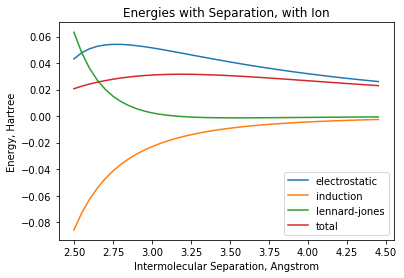

In [160]:
# Plot Energies
plt.title("Energies with Separation, with Ion")
plt.xlabel("Intermolecular Separation, Angstrom")
plt.ylabel('Energy, Hartree')
plt.plot(R/angstrom,e2)
plt.plot(R/angstrom,i2)
plt.plot(R/angstrom,lj2)
plt.plot(R/angstrom,tot2)
plt.legend(['electrostatic','induction','lennard-jones','total'])